In [12]:
import jax.numpy as jnp
from jax import grad, hessian, jacobian, vmap, random
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def get_rbf(gamma):
    def kernel(x, y):
        return jnp.exp(-gamma*jnp.sum((x-y)**2))
    return kernel

def get_lap(f, argnums):
    def laplacian(x, y):
        return jnp.trace(hessian(f, argnums=argnums)(x, y))
    return laplacian

def f(x, y):
    return 2*jnp.pi*(jnp.sin(2*np.pi*x))*jnp.cos(2*np.pi*y) 

k = get_rbf(gamma=0.5)

In [18]:
lapx = get_lap(k, argnums=0) # laplacian wrt to first input x
bilap = get_lap(lap_x, argnums=1) # laplacian wrt to second input y

# I want them to work on batches, but need all to go to all. So one to all, then all to one..?
vec_k = vmap(vmap(k, in_axes = (None,0)), in_axes=(0, None)) 
vec_lapx = vmap(vmap(lap_x, in_axes = (None,0)), in_axes=(0, None)) 
vec_bilap = vmap(vmap(bilap, in_axes = (None,0)), in_axes = (0, None))

(220, 220)


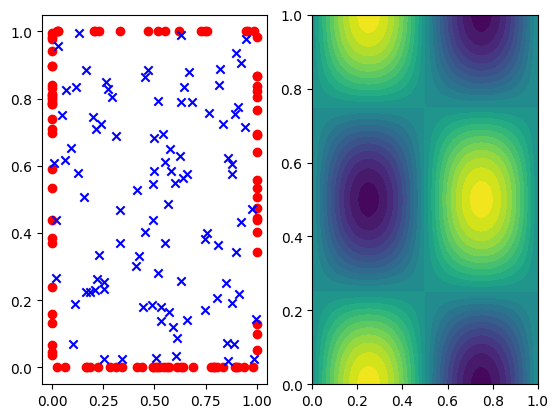

In [13]:
I = 100
B = 100
n_grid = 220
p = 0.5
key1 = random.PRNGKey(0)
key2 = random.PRNGKey(1)

X_I = random.uniform(key1, shape=(I, 2))
bd1 = jnp.concatenate((random.bernoulli(key1, p=p, shape=(B//2, 1)), random.uniform(key2, shape=(B//2, 1))), axis=1)
bd2 = jnp.concatenate((random.uniform(key1, shape=(B//2, 1)), random.bernoulli(key2, p=p, shape=(B//2, 1))), axis=1)
X_B = jnp.concatenate((bd1, bd2), axis=0)

fig, axs = plt.subplots(1, 2, )
axs[0].scatter(X_B[:, 0], X_B[:, 1], color='red', marker='o')
axs[0].scatter(X_I[:, 0], X_I[:, 1], color='blue', marker='x')

x = jnp.linspace(0, 1, n_grid)
y = jnp.linspace(0, 1, n_grid)
X, Y = jnp.meshgrid(x, y)

axs[1].scatter(X, Y, s=0.1)
axs[1].contourf(X, Y, f(X, Y), levels=20)
print(f(X, Y).shape)

Setup $K \alpha = y$

In [14]:
# Should be f(x_1), ... f(x_B) and then on boundary
f_I = f(X_I[:, 0], X_I[:, 1])
f_B = jnp.zeros((X_B.shape[0],))
f_vec = jnp.hstack([f_I, f_B])
print(f_vec.shape)

(200,)


In [42]:
x = jnp.array([0.5, 0.5]).reshape(1, -1)

print(vec_lapx(x, X_I).shape)

(1, 100)


In [ ]:
K_II = vec_bilap(X_I, X_I)
K_IB = vec_lapx(X_I, X_B)
K_BI = jnp.copy(K_IB).T
K_BB = vec_k(X_B, X_B)

K = jnp.block([
     [K_II, K_BI],
     [K_IB, K_BB]
    ])

alpha = jnp.linalg.solve(K + 0.005*jnp.eye(K.shape[0]), f_vec)

print(f"Condition number of K is {jnp.linalg.cond(K + 0.005*jnp.eye(K.shape[0]))}")


Condition number of K is 1129391.125
(200,)


Solution is given by $u(x) = \bm{\phi}(K(x, \cdot)) K_{\phi\phi}^{-1} y = \bm{\phi}(K(x, \cdot)) \bm{\alpha}$. However, we would like to compute solution on more than one point at a time, say at $\mathcal{X}_{\textrm{test}} = \{x_i\}$. This becomes $$u(\mathcal{X}_{\textrm{test}}) = \bm{\phi}(K(\mathcal{X}_{\textrm{test}}, \cdot)) K_{\phi\phi}^{-1} y$$

In [ ]:
X_test = random.uniform(key1, shape=(1000, 2))

def u(x):
    basis = jnp.hstack([vec_lapx(x.reshape(1, -1), X_I), vec_k(x.reshape(1, -1), X_B)])
    return (basis @ alpha).squeeze()

vec_u = vmap(u, in_axes=0)

print(u(x))
print(vec_u(X_test).shape)

-1.6048756


TypeError: sub got incompatible shapes for broadcasting: (2000,), (2,).